In [1]:
import os
#os.chdir('20250824_potato_sprout_project')
os.getcwd()

'D:\\0_Sundry\\Jupyterlab\\20250826_potato_sprout_project'

In [2]:
import tensorflow as tf
from tensorflow.keras.applications.resnet_v2 import preprocess_input
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.utils import class_weight
import random

SEED = 825

np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# 定義參數
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
DATA_DIR = 'data/'

# 讀取訓練資料
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=f'{DATA_DIR}train',
    labels='inferred',
    label_mode='binary', # 二元分類
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

# 讀取驗證資料
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=f'{DATA_DIR}validation',
    labels='inferred',
    label_mode='binary',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=SEED
)

Found 749 files belonging to 2 classes.
Found 260 files belonging to 2 classes.


In [3]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])
# data_augmentation = tf.keras.Sequential([
#     tf.keras.layers.RandomFlip('horizontal_and_vertical'),
#     tf.keras.layers.RandomRotation(0.3),
#     tf.keras.layers.RandomZoom(0.3),
#     tf.keras.layers.RandomBrightness(0.3),  # 增加範圍覆蓋149.29
#     tf.keras.layers.RandomContrast(0.3),
#     tf.keras.layers.Lambda(lambda x: tf.image.random_saturation(x, 0.5, 2.0)),  # 覆蓋高飽和度
#     tf.keras.layers.Lambda(lambda x: tf.image.random_hue(x, 0.1)),
# ])

In [4]:
# # 建立模型
# inputs = tf.keras.Input(shape=IMAGE_SIZE + (3,))
# x = data_augmentation(inputs) # 應用資料增強
# x = tf.keras.applications.mobilenet_v2.preprocess_input(x) # MobileNetV2 專用的預處理
# x = base_model(x, training=False) # 凍結層需要設定 training=False
# x = tf.keras.layers.GlobalAveragePooling2D()(x) # 將特徵圖轉換為向量
# x = tf.keras.layers.Dropout(0.2)(x) # 防止過擬合
# outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x) # 輸出層，使用 sigmoid 進行二元分類

# model = tf.keras.Model(inputs, outputs)

In [5]:
# # 編譯模型
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#     loss='binary_crossentropy', # 二元分類的標準損失函數
#     metrics=['accuracy']
# )



# # 訓練模型
# # EPOCHS = 15
# # history = model.fit(
# #     train_dataset,
# #     validation_data=validation_dataset,
# #     epochs=EPOCHS,
# #     class_weight=class_weights
# # )

In [6]:
# --- 1. 建立並進行第一階段訓練 (只訓練分類頭) ---

# 載入 base_model 並凍結
base_model = tf.keras.applications.ResNet50V2(
    input_shape=IMAGE_SIZE + (3,), 
    include_top=False, 
    weights='imagenet')
base_model.trainable = False

# 建立完整模型
inputs = tf.keras.Input(shape=IMAGE_SIZE + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.4)(x) # 這裡的 Dropout 也可以考慮增加到 0.4
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

# 第一階段編譯 (使用較高的學習率)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 計算 class_weight
# y_true 包含了所有驗證集的標籤，我們可以借用它來計算權重
# 注意：在真實流程中，應該從 train_dataset 中計算
train_labels = np.concatenate([y for x, y in train_dataset], axis=0).flatten()
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(zip(np.unique(train_labels), weights))
print(f"計算出的類別權重: {class_weights}")

print("--- 開始第一階段訓練 ---")
# 先訓練幾個 epoch (例如 10 個)
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=validation_dataset,
                    class_weight=class_weights)


# --- 2. 進行第二階段訓練 (微調 Fine-Tuning) ---
print("\n--- 開始第二階段微調 ---")

# 解凍 base_model
base_model.trainable = True

# 凍結前面的層，只讓後面的層參與訓練
fine_tune_at = 80 # 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# 第二階段編譯 (使用非常低的學習率)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6), # 學習率降到 0.00001(1e-5)
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# 建立一個 ModelCheckpoint 回呼
# 我們監控 'val_auc'，並且只保存分數最高的模型
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "best_potato_model.keras",      # 存檔路徑
    save_best_only=True,            # 只保存最好的
    monitor="val_auc",              # 監控的指標 (我們現在關心 AUC)
    mode="max"                      # 我們希望 AUC 越大越好
)

# 繼續訓練模型 (再訓練幾個 epoch)
fine_tune_epochs = 10
total_epochs = 10 + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1], # 從上次結束的地方繼續
                         validation_data=validation_dataset,
                         class_weight=class_weights,
                         callbacks=[checkpoint_cb]
                        )

計算出的類別權重: {0.0: 0.9409547738693468, 1.0: 1.066951566951567}
--- 開始第一階段訓練 ---
Epoch 1/10
47/47 [==============================] - 16s 142ms/step - loss: 0.5415 - accuracy: 0.7250 - val_loss: 0.3750 - val_accuracy: 0.8346
Epoch 2/10
47/47 [==============================] - 6s 128ms/step - loss: 0.3781 - accuracy: 0.8385 - val_loss: 0.2831 - val_accuracy: 0.8769
Epoch 3/10
47/47 [==============================] - 6s 122ms/step - loss: 0.2931 - accuracy: 0.8865 - val_loss: 0.2479 - val_accuracy: 0.9038
Epoch 4/10
47/47 [==============================] - 6s 123ms/step - loss: 0.2885 - accuracy: 0.8825 - val_loss: 0.2330 - val_accuracy: 0.9038
Epoch 5/10
47/47 [==============================] - 6s 123ms/step - loss: 0.2733 - accuracy: 0.8852 - val_loss: 0.2190 - val_accuracy: 0.9115
Epoch 6/10
47/47 [==============================] - 6s 132ms/step - loss: 0.2644 - accuracy: 0.8785 - val_loss: 0.2085 - val_accuracy: 0.9269
Epoch 7/10
47/47 [==============================] - 6s 128ms/step - lo


模型評估開始
17/17 [==============================] - 2s 72ms/step

分類報告 (Classification Report):
              precision    recall  f1-score   support

not_sprouted     0.9528    0.9837    0.9680       123
    sprouted     0.9850    0.9562    0.9704       137

    accuracy                         0.9692       260
   macro avg     0.9689    0.9700    0.9692       260
weighted avg     0.9697    0.9692    0.9692       260

AUC-ROC 分數: 0.9957



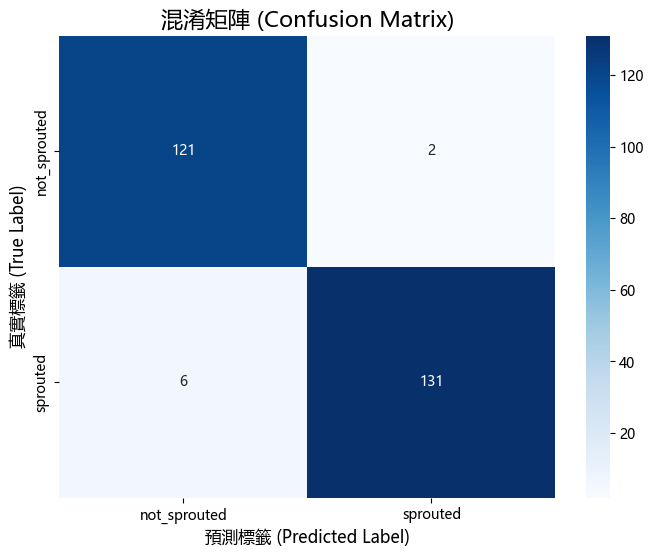

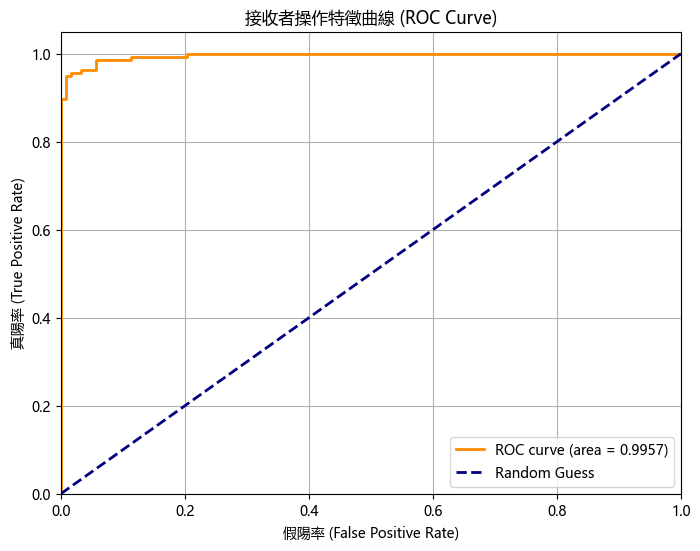


訓練過程視覺化


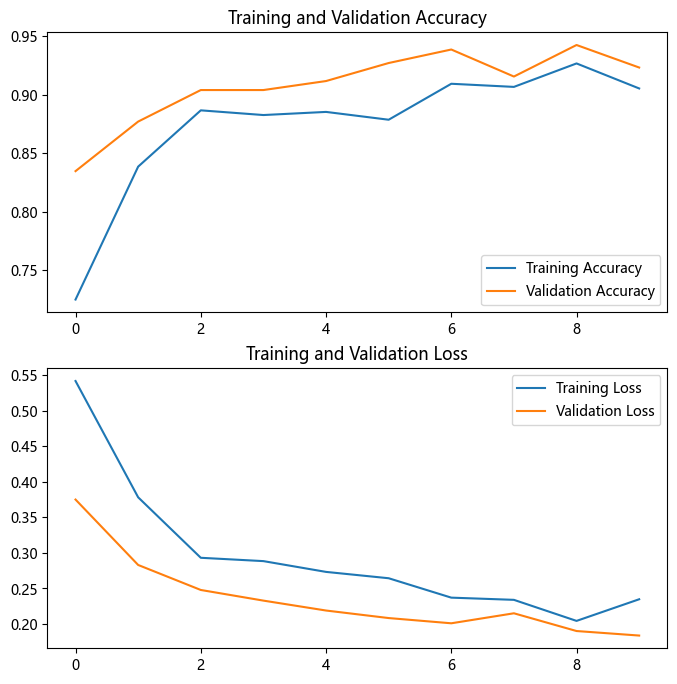

In [7]:
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei'] # 例如 ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False # 解決負號顯示問題
class_names = train_dataset.class_names
# --- 步驟 2: 新增模型評估區塊 ---
print("\n" + "="*50)
print("模型評估開始")
print("="*50)

# 1. 取得真實標籤 (y_true) 和預測機率 (y_pred_prob)
# 從 validation_dataset 中提取所有圖片的真實標籤
y_true = np.concatenate([y for x, y in validation_dataset], axis=0)
y_true = y_true.flatten().astype(int) # 攤平成一維陣列

# 使用模型進行預測，得到的是機率值
y_pred_prob = model.predict(validation_dataset).flatten()

# 根據 0.5 的閾值，將機率轉換為 0 或 1 的預測類別
y_pred = (y_pred_prob > 0.5).astype(int)

# 2. 計算並顯示評估指標
print("\n分類報告 (Classification Report):")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

auc_score = roc_auc_score(y_true, y_pred_prob)
print(f"AUC-ROC 分數: {auc_score:.4f}\n")


# 3. 繪製混淆矩陣 (Confusion Matrix)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('混淆矩陣 (Confusion Matrix)', fontsize=16)
plt.xlabel('預測標籤 (Predicted Label)', fontsize=12)
plt.ylabel('真實標籤 (True Label)', fontsize=12)
plt.show()


# 4. 繪製 ROC 曲線
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('假陽率 (False Positive Rate)')
plt.ylabel('真陽率 (True Positive Rate)')
plt.title('接收者操作特徵曲線 (ROC Curve)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


# --- 原有的程式碼: 繪製訓練歷史曲線 ---
print("\n" + "="*50)
print("訓練過程視覺化")
print("="*50)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [11]:
# # 假設您的模型變數叫做 model，並且已經訓練完畢
# # history = model.fit(...)  <-- 您的訓練程式碼

# # 加上這一行來儲存模型
# model.save('20250826_potato_classifier_model.keras')

# print("模型已成功儲存為 potato_classifier_model.keras")

模型已成功儲存為 potato_classifier_model.keras


In [9]:
# import cv2
# import numpy as np

# # 載入一張測試圖片
# img_path = 'for_test/test4.jpg'
# img = cv2.imread(img_path)
# img = cv2.resize(img, IMAGE_SIZE)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # 轉換為 RGB
# img_array = tf.expand_dims(img, 0) # 建立一個 batch

# prediction = model.predict(img_array)
# score = prediction[0][0]

# if score > 0.5:
#     print(f"這顆馬鈴薯已發芽的機率是: {100 * score:.2f}%")
# else:
#     print(f"這顆馬鈴薯未發芽的機率是: {100 * (1 - score):.2f}%")

In [10]:
import cv2
import numpy as np
import os
import tensorflow as tf # 您的程式碼似乎使用 TensorFlow，所以在此匯入

# --- 請先在此區域進行設定 ---

# 假設您的模型和圖片尺寸已經定義好了
# 如果沒有，請取消以下註解並設定
# from tensorflow.keras.models import load_model
# model = load_model('your_model.h5') # 載入您訓練好的模型
# IMAGE_SIZE = (224, 224) # 設定模型輸入的圖片尺寸

# 指定包含所有圖片的資料夾路徑
folder_path = 'for_test/S/' # 請將 'for_test' 替換成您的資料夾名稱

# --- 主要處理邏輯 ---

# 檢查指定的路徑是否存在且是一個資料夾
if not os.path.isdir(folder_path):
    print(f"錯誤：找不到資料夾 '{folder_path}'")
else:
    # 取得資料夾中所有檔案的名稱
    all_files = os.listdir(folder_path)
    
    # 篩選出圖片檔案 (可以根據需求增加或修改附檔名)
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']
    image_files = [f for f in all_files if os.path.splitext(f)[1].lower() in image_extensions]

    if not image_files:
        print(f"在 '{folder_path}' 資料夾中找不到任何支援的圖片檔案。")
    else:
        print(f"在 '{folder_path}' 中找到 {len(image_files)} 張圖片，開始進行分析...\n")

        # 遍歷每一張圖片
        for image_name in image_files:
            # 組合出完整的圖片檔案路徑
            img_path = os.path.join(folder_path, image_name)
            
            # --- 以下是您原本的處理邏輯，放入迴圈中 ---
            
            # 載入一張圖片
            img = cv2.imread(img_path)

            # 檢查圖片是否成功載入
            if img is None:
                print(f"警告：無法讀取圖片 '{img_path}'，將跳過此檔案。\n")
                continue # 繼續處理下一張圖片
            
            print(f"--- 正在分析: {image_name} ---")

            # 調整圖片大小並轉換顏色空間
            img = cv2.resize(img, IMAGE_SIZE)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # 轉換為 RGB
            img_array = tf.expand_dims(img, 0) # 為模型預測建立一個 batch

            # 進行預測
            prediction = model.predict(img_array)
            score = prediction[0][0]

            # 顯示結果
            if score > 0.5:
                print(f"這顆馬鈴薯已發芽的機率是: {100 * score:.2f}%\n")
            else:
                print(f"這顆馬鈴薯未發芽的機率是: {100 * (1 - score):.2f}%\n")

在 'for_test/S/' 中找到 50 張圖片，開始進行分析...

--- 正在分析: 53135_0.jpg ---
1/1 [==============================] - 1s 765ms/step
這顆馬鈴薯已發芽的機率是: 100.00%

--- 正在分析: GREEN.jpg ---
1/1 [==============================] - 0s 22ms/step
這顆馬鈴薯已發芽的機率是: 100.00%

--- 正在分析: GREEN02.jpg ---
1/1 [==============================] - 0s 25ms/step
這顆馬鈴薯未發芽的機率是: 97.52%

--- 正在分析: GREEN03.jpg ---
1/1 [==============================] - 0s 29ms/step
這顆馬鈴薯已發芽的機率是: 89.92%

--- 正在分析: imgi_11_potato-chtting-prior-to-planting-out.jpg ---
1/1 [==============================] - 0s 22ms/step
這顆馬鈴薯已發芽的機率是: 100.00%

--- 正在分析: imgi_11_seed-potatoes-chitting-in-egg-box-on-white.jpg ---
1/1 [==============================] - 0s 24ms/step
這顆馬鈴薯已發芽的機率是: 99.94%

--- 正在分析: imgi_13_top-view-of-old-box-with-sackcloth-and-pile-of-sprouted-potatoes-in-it.jpg ---
1/1 [==============================] - 0s 26ms/step
這顆馬鈴薯已發芽的機率是: 99.99%

--- 正在分析: imgi_14_old-potato-bulbs-with-young-sprouts-ready-for-planting.jpg ---
1/1 [=======================